This implementation uses fully convolutional neural network for Newspaper Segmentation in JPEG domain.

* Uses Manually created dataset of newspaper including RGB image and the ground truth masked image for training and validation for classification regions of newspaper on text, picture and background areas. It contains 290 images of English newspapers. There are 4 classes: Article area, picture area, background, Heading .

*  Image used in this implementaion is a RGB colorspace image of the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np # linear algebra
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from google.colab import files

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

In [ ]:
IMAGE_LIB = '/content/drive/MyDrive/MiniProject/ManualDataset/'
IMG_HEIGHT, IMG_WIDTH = 256,256
SEED = 42

In [ ]:
all_masks = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-6:-4] == '_m']
all_images = []
for i,name in enumerate(all_masks):
    for x in sorted(os.listdir(IMAGE_LIB)):
        if x.startswith(name[:-6]) and x[-6:-4] != '_m':
            all_images.append(x)
            break

In [ ]:
x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name,cv2.IMREAD_COLOR).astype('float32')/255
    im = cv2.resize(im, (IMG_WIDTH, IMG_HEIGHT))
    x_data[i] = im

y_data = np.empty((len(all_masks), IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
for i, name in enumerate(all_masks):
    im = cv2.imread(IMAGE_LIB + name,cv2.IMREAD_COLOR).astype('float32')/255
    im = cv2.resize(im,(IMG_WIDTH, IMG_HEIGHT))
    y_data[i] = im

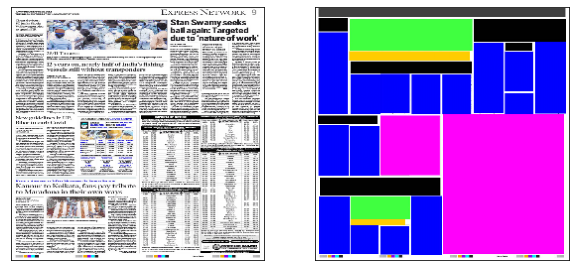

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].imshow(x_data[0])
ax[1].imshow(y_data[0])
plt.show()

In [ ]:
x_data.shape

(145, 256, 256, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

In [ ]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(7,7), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=3, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 1216        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 16) 6416        conv2d_77[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_78[0][0]                  
____________________________________________________________________________________________

In [ ]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator().flow(x_train, y=None, batch_size=batch_size, seed=SEED)
    mask_generator = ImageDataGenerator().flow(y_train, y=None, batch_size=batch_size, seed=SEED)
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

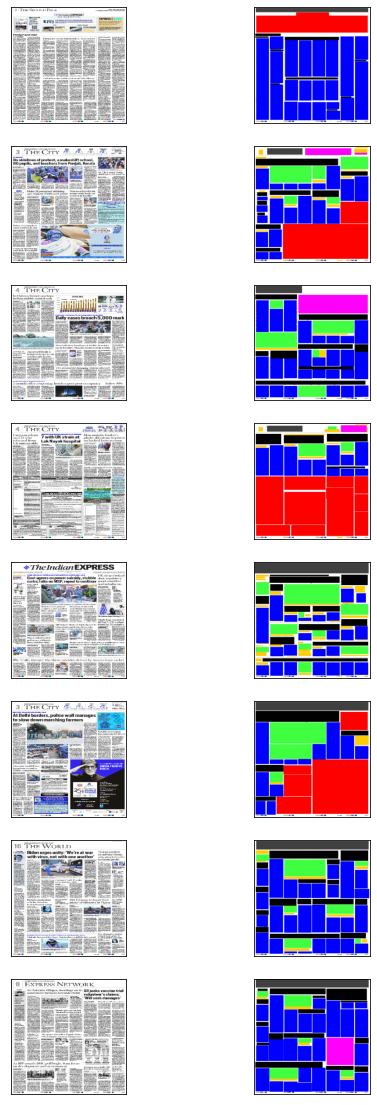

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 16))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].set_yticks([])
    ax[i,0].imshow(image_batch[i,:,:,:])
    ax[i,1].imshow(mask_batch[i,:,:,:])
plt.show()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
weight_saver = ModelCheckpoint('RGB.h5', monitor='val_accuracy', save_best_only=True)
early = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='min')

In [ ]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 100,
                           validation_data = (x_test, y_test),
                           epochs=20, verbose=1,
                           callbacks = [weight_saver])

In [ ]:
trainingscore = model.evaluate(x_train, y_train, batch_size=8, verbose=0)
print(trainingscore[0])
print(trainingscore[1])

testingscore = model.evaluate(x_test, y_test, batch_size=8, verbose=0)
print(testingscore[0])
print(testingscore[1])

0.26482704281806946
0.7785658240318298
0.38430023193359375
0.7251472473144531


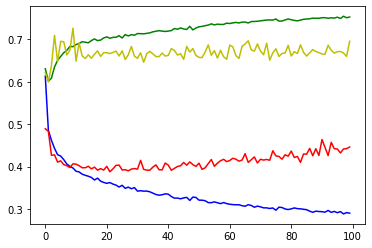

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.plot(hist.history['accuracy'], color='g')
plt.plot(hist.history['val_accuracy'], color='y')
plt.show()

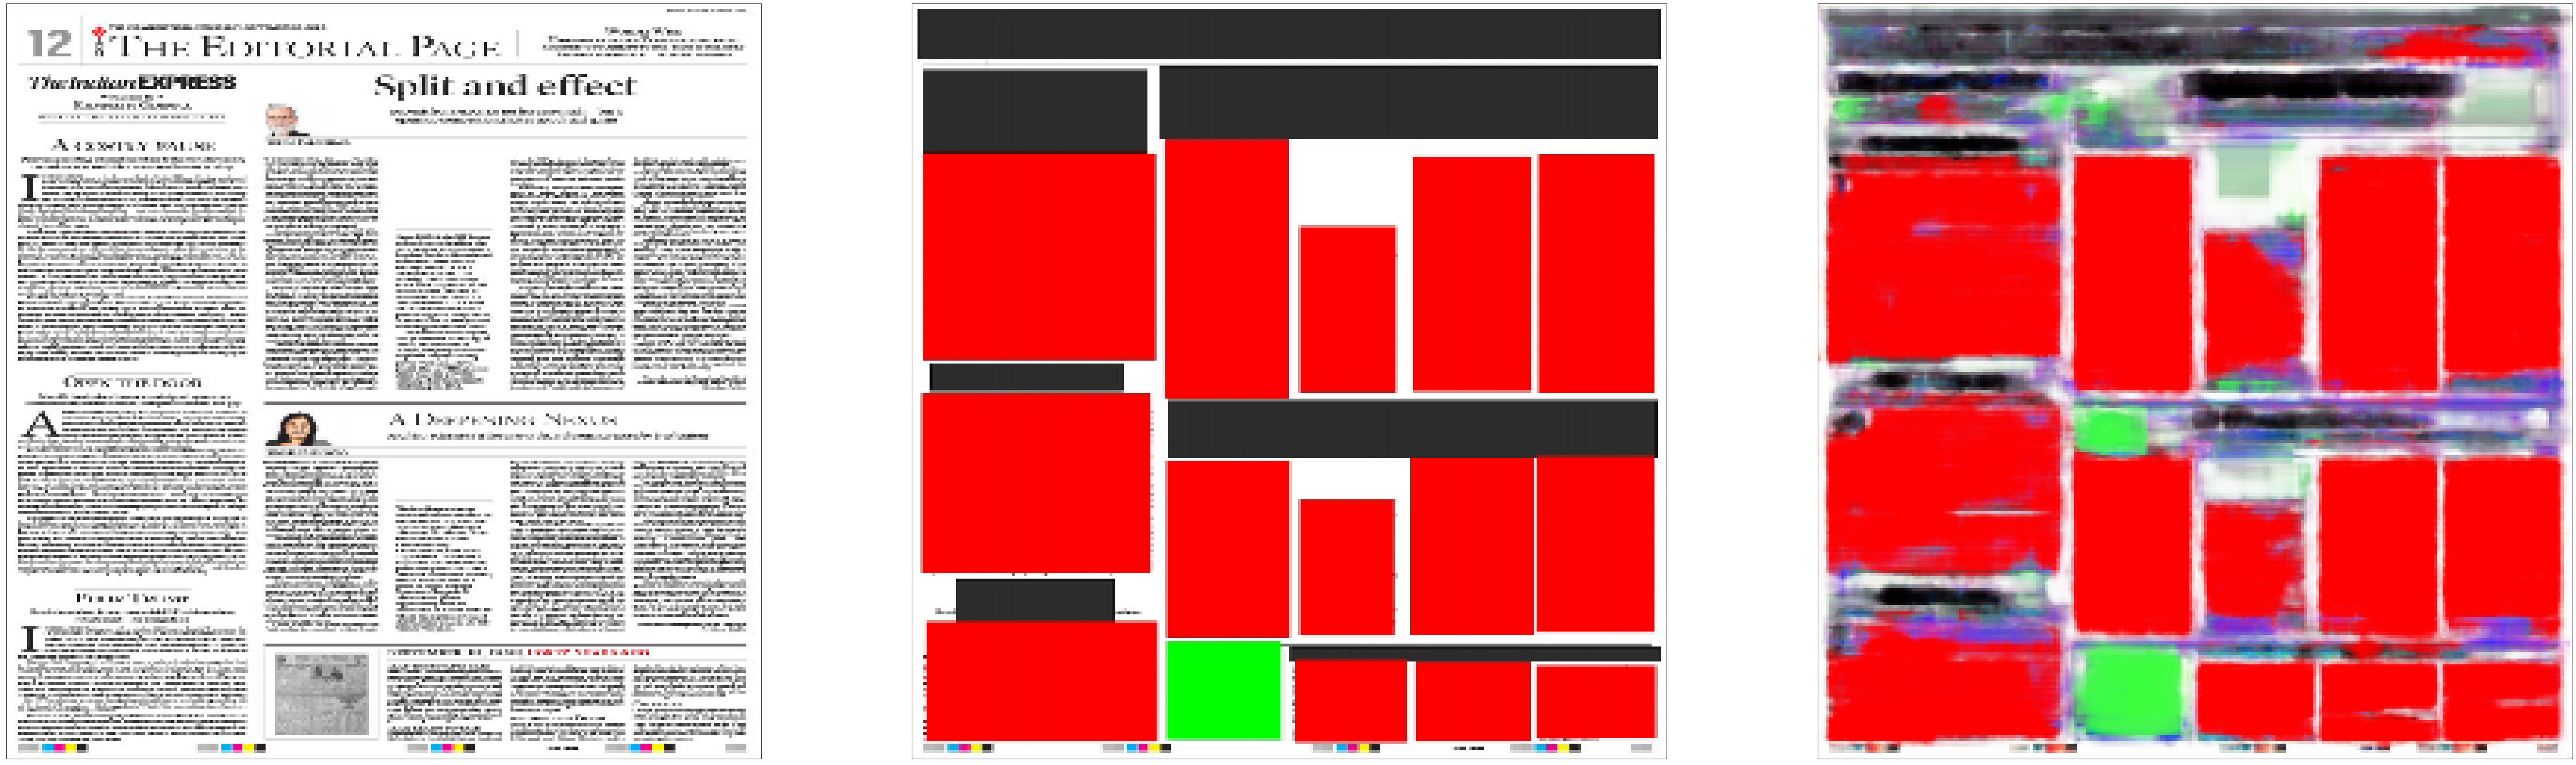

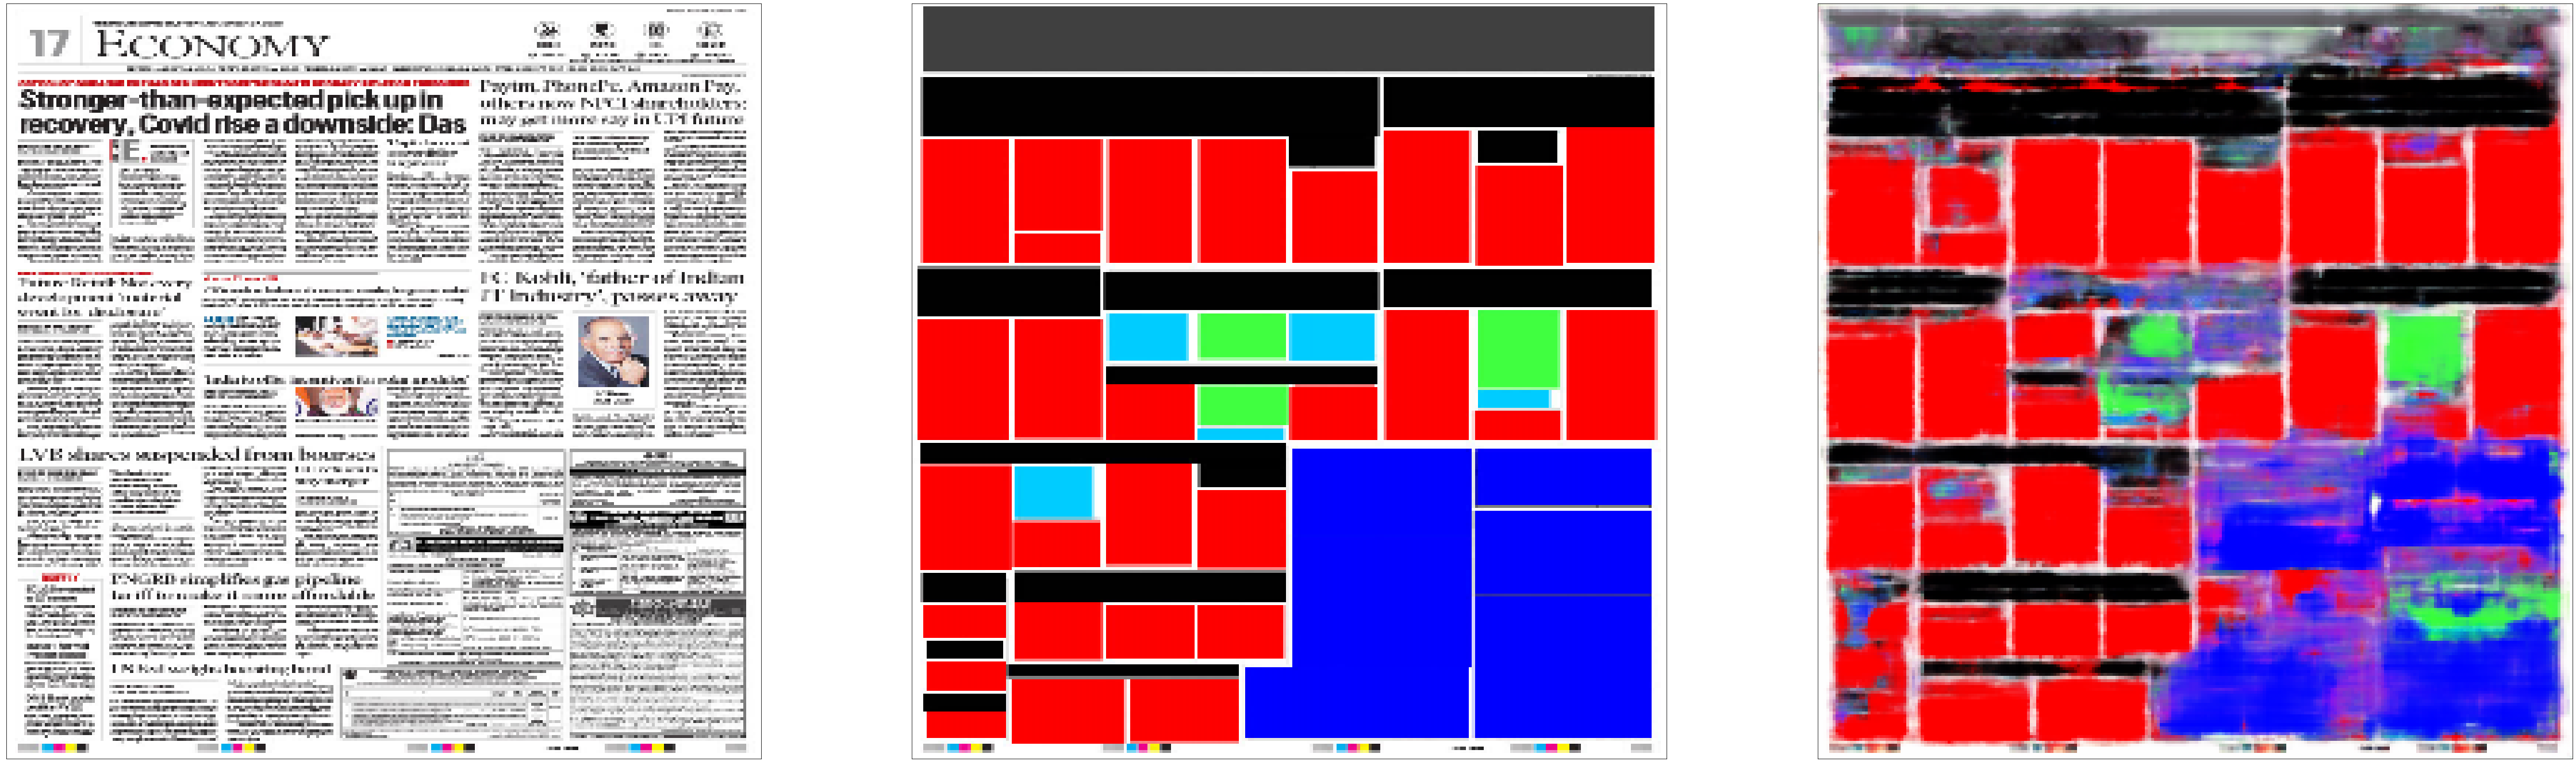

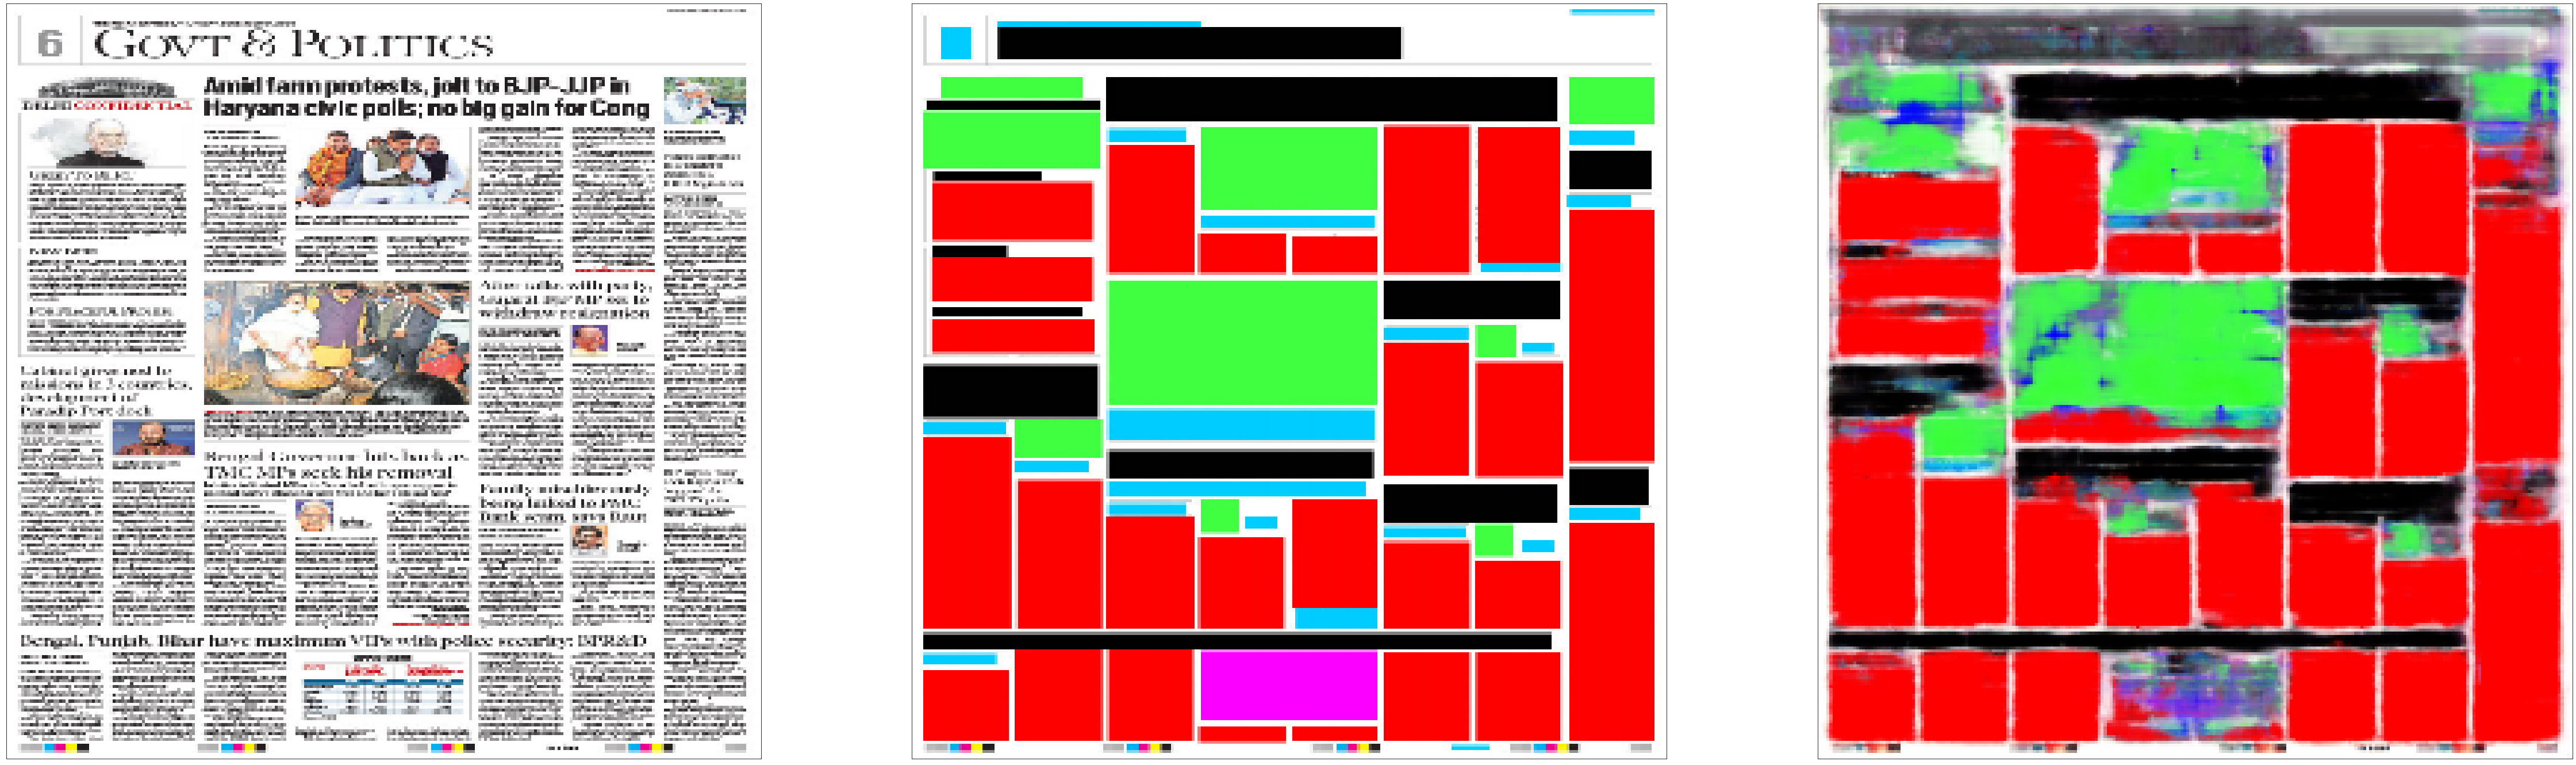

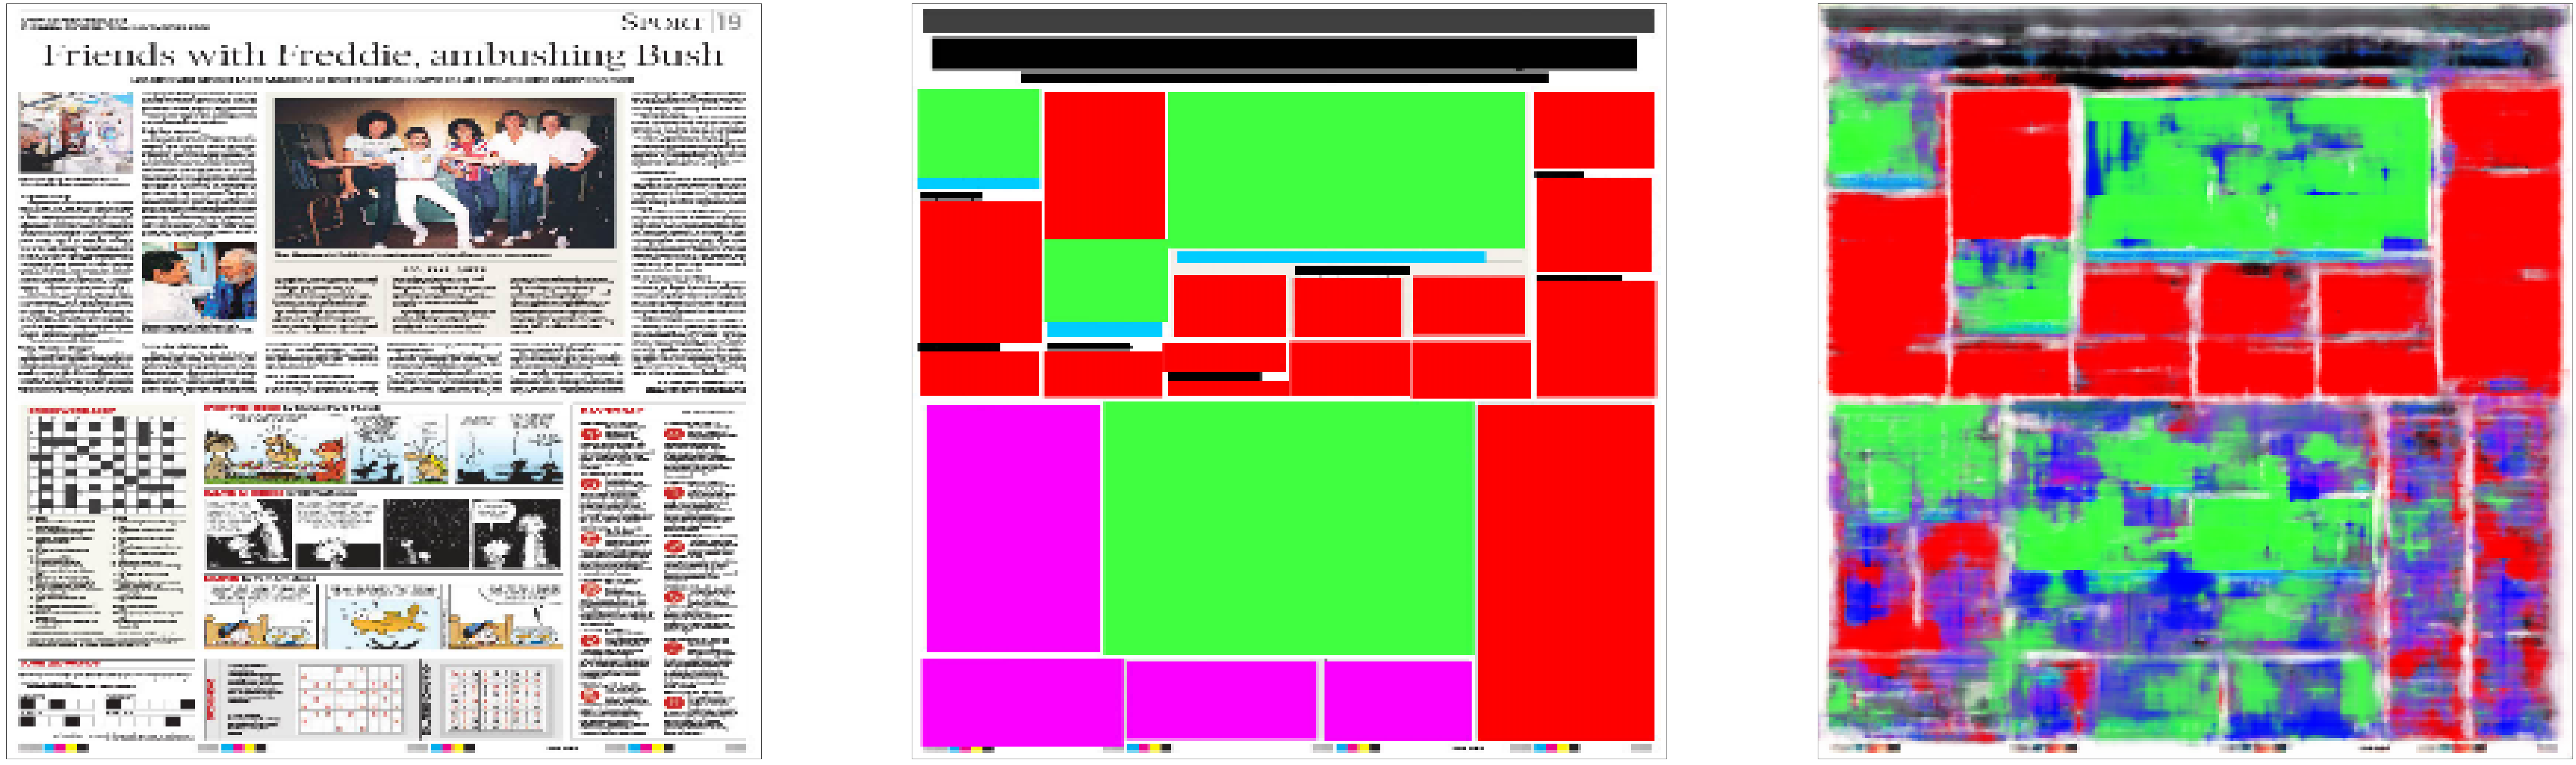

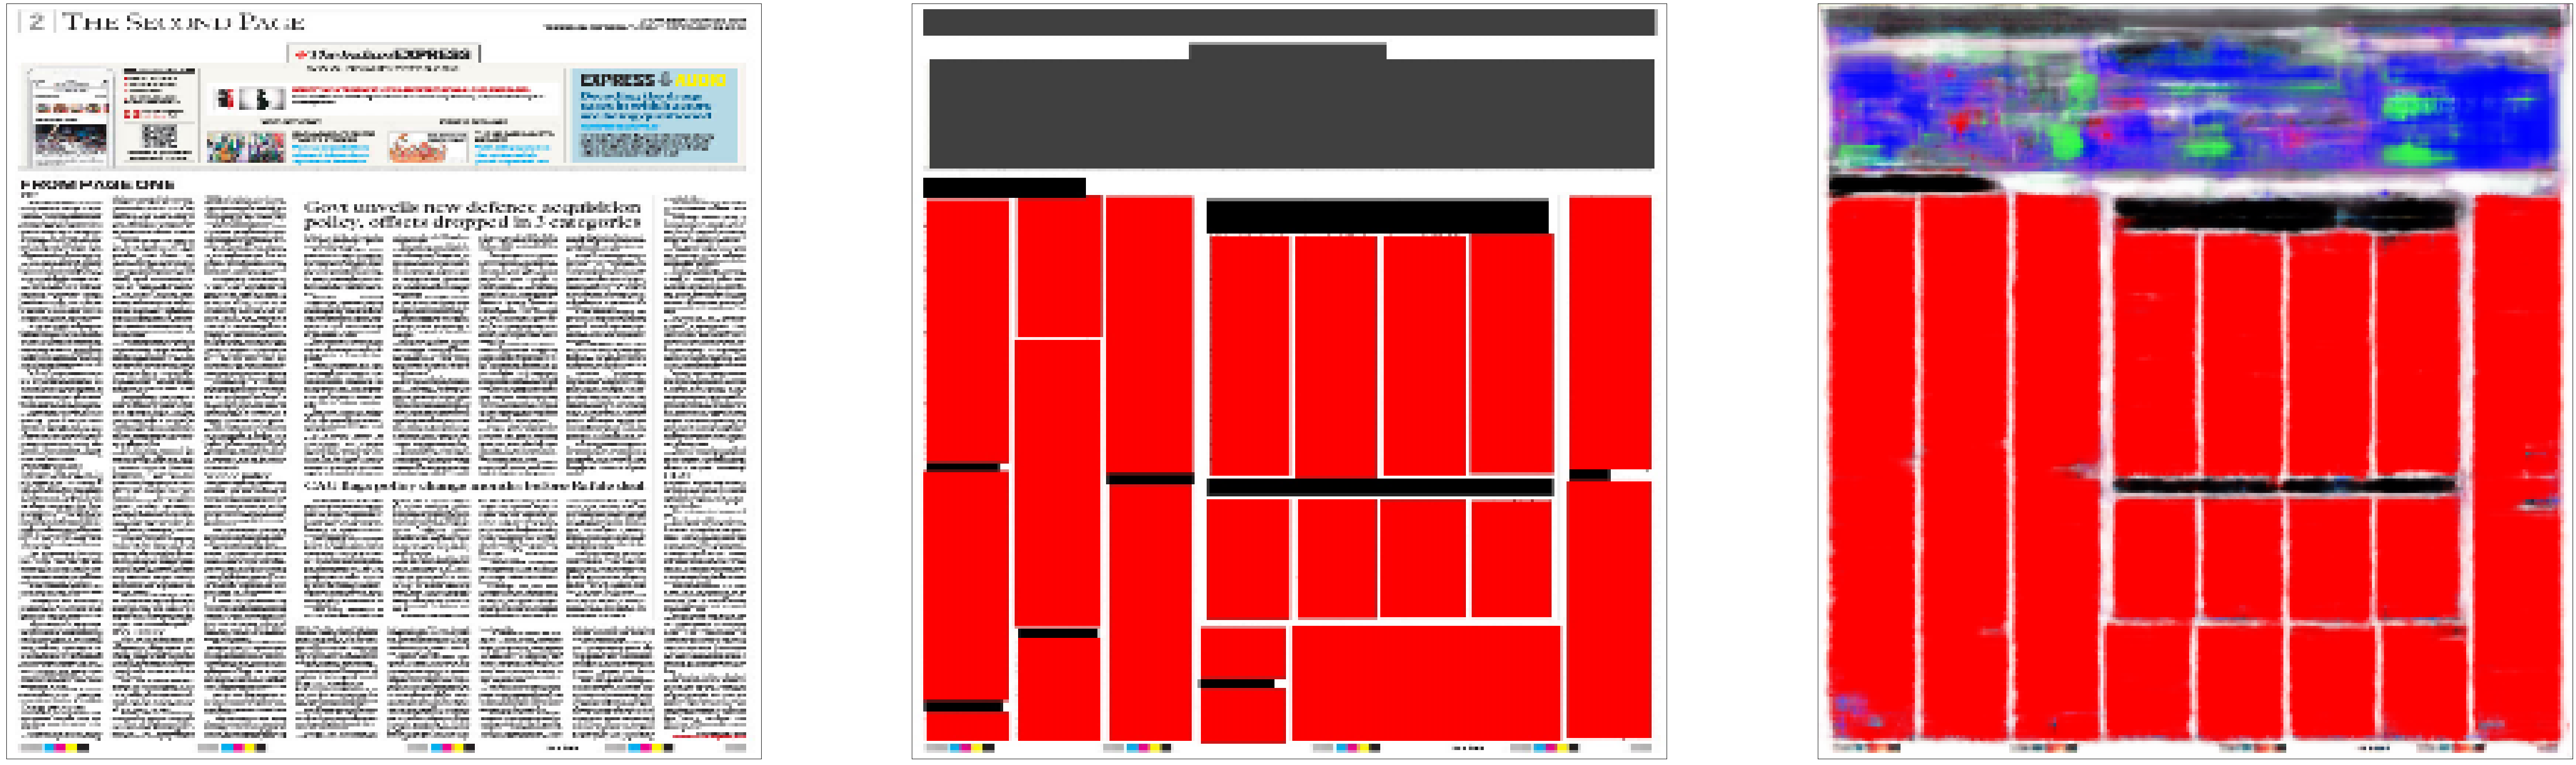

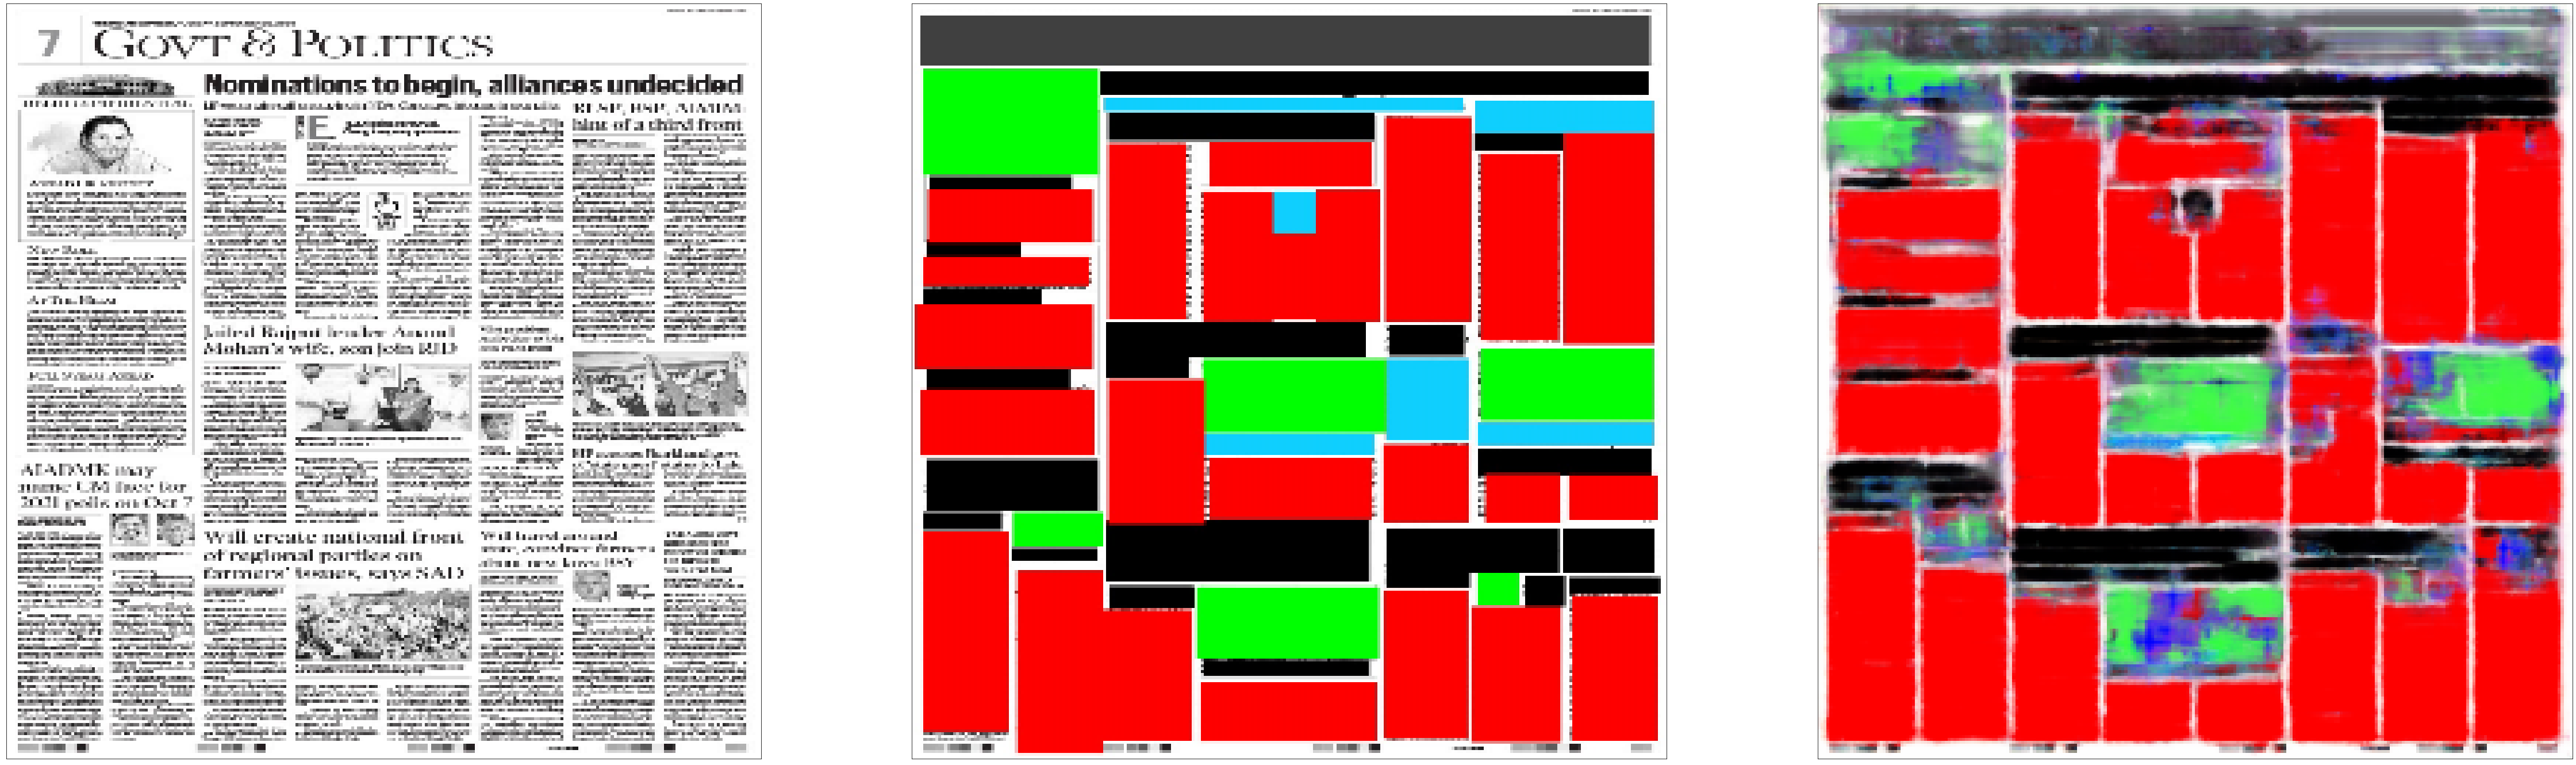

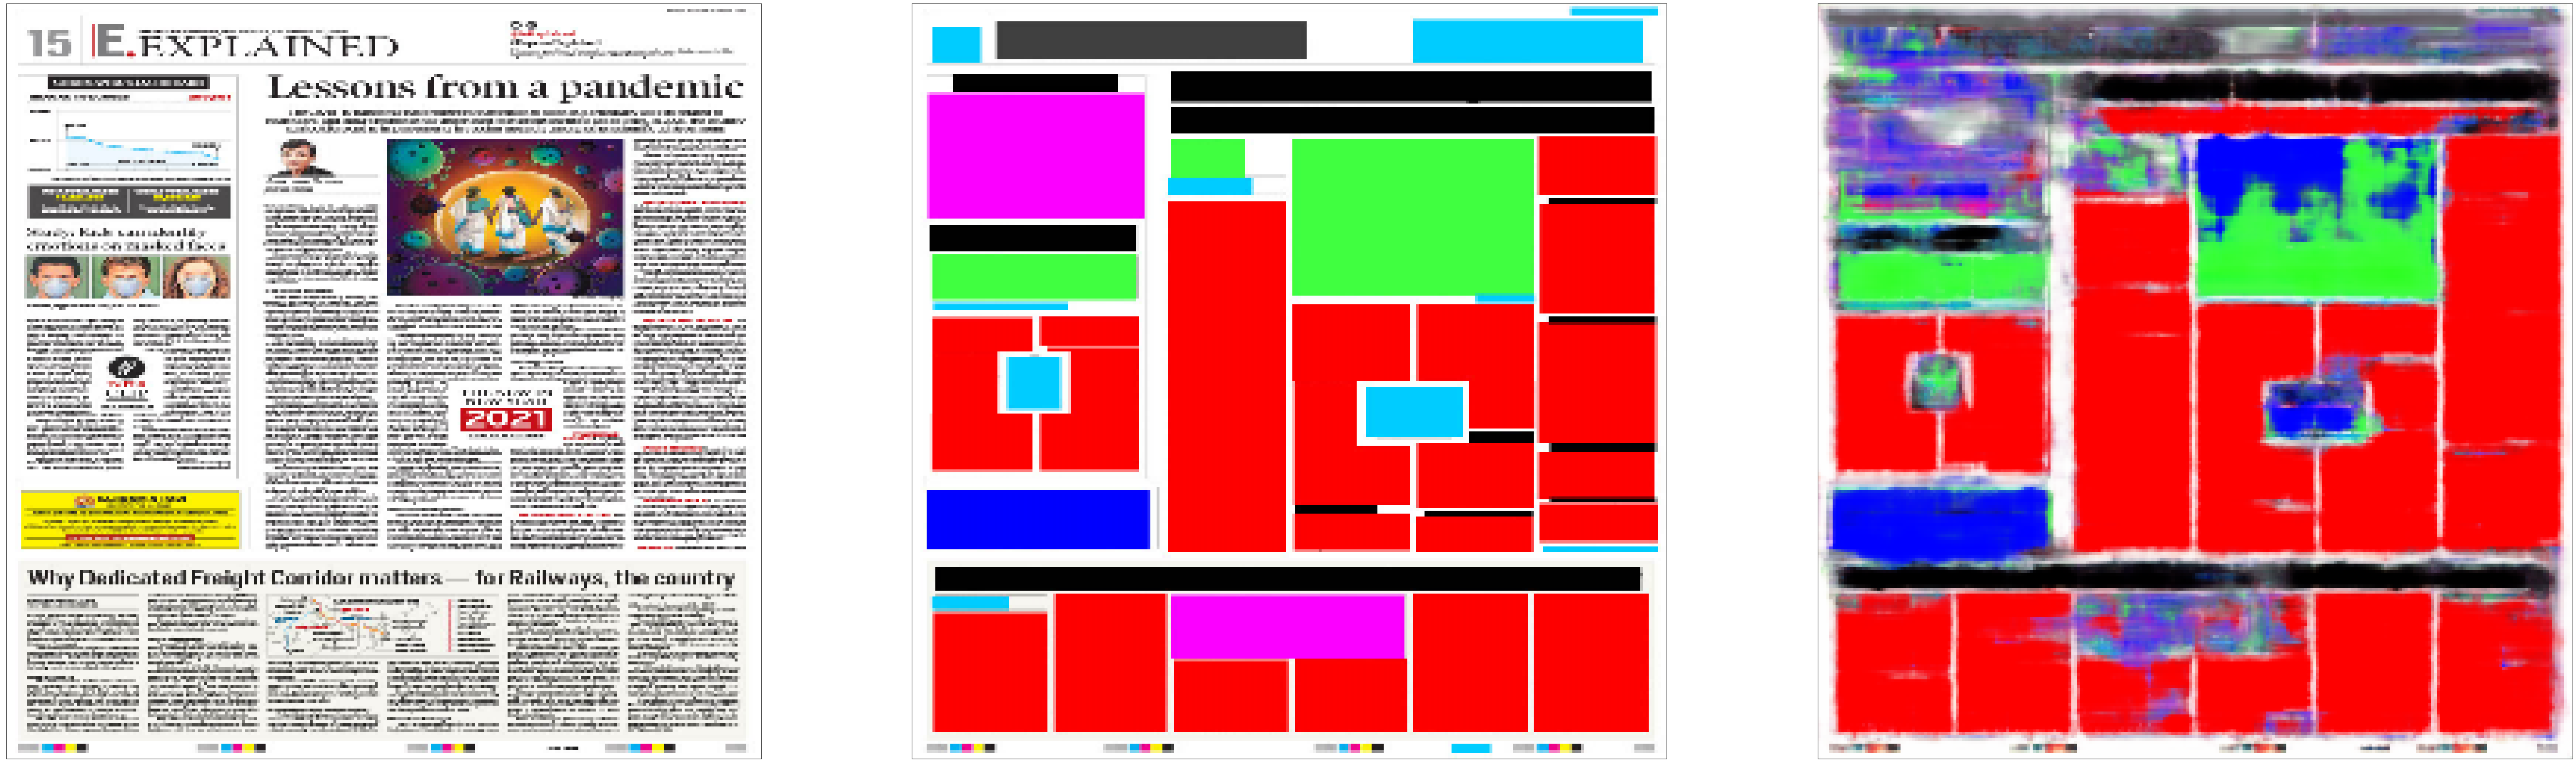

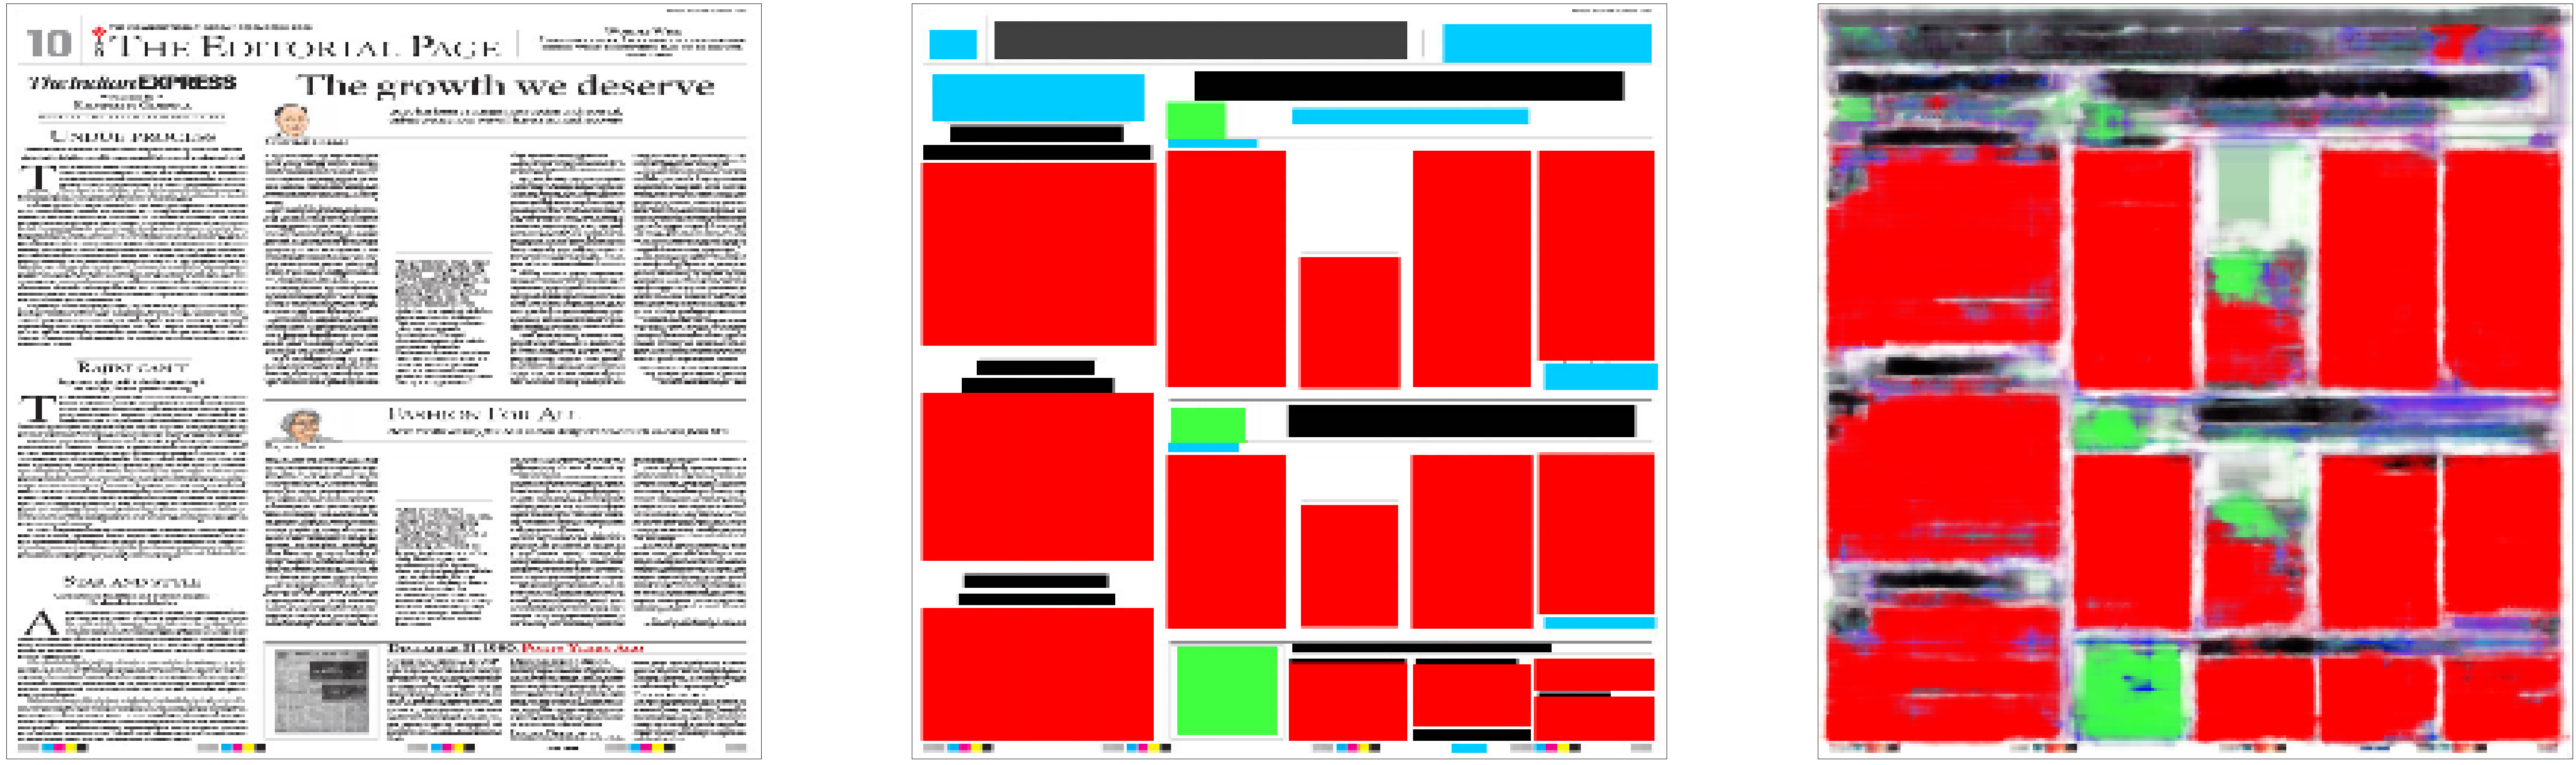

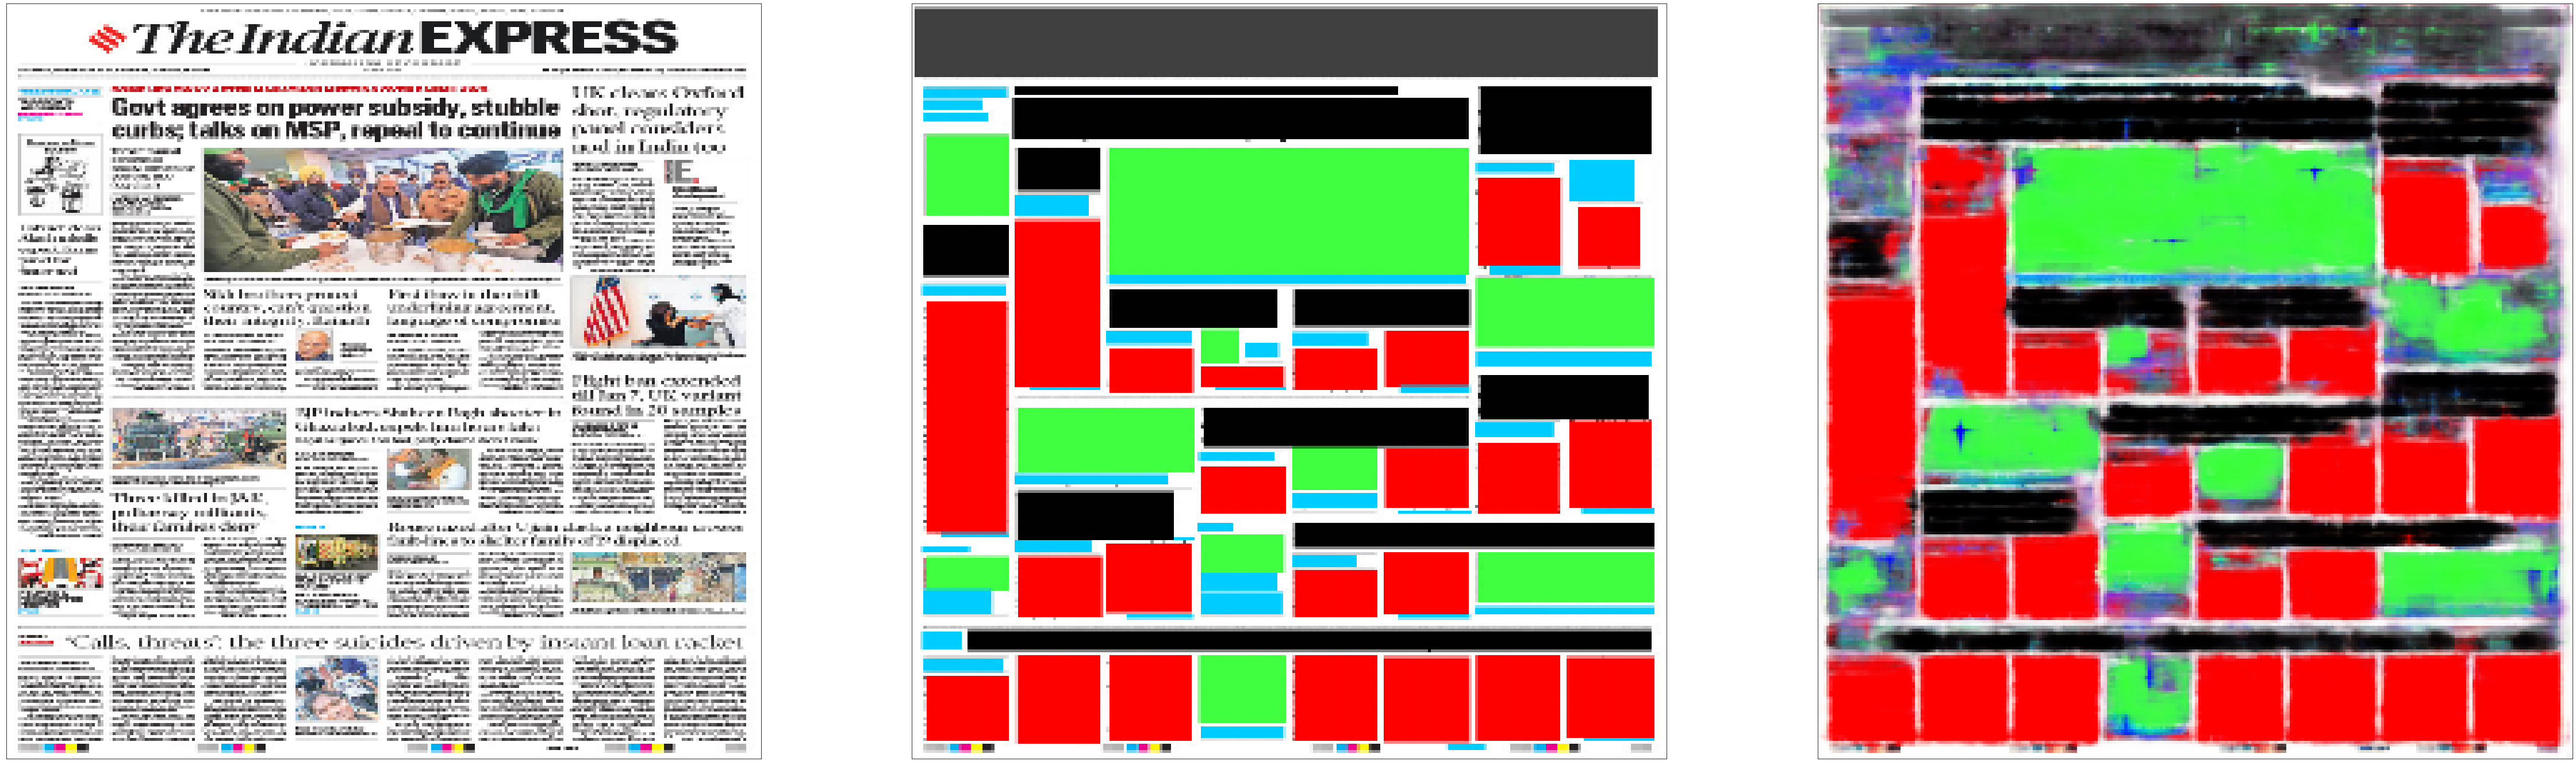

In [ ]:
y_hat = model.predict(x_test)
for i in range(0,9):
  offset = 0
  im_rows = 1
  im_cols = 3
  fig, ax = plt.subplots(offset + im_rows, im_cols, figsize=(80,80))
  ax[0].set_xticks([])
  ax[1].set_xticks([])
  ax[2].set_xticks([])
  ax[0].set_yticks([])
  ax[1].set_yticks([])
  ax[2].set_yticks([])
  ax[0].imshow(x_test[i,:,:,:])
  ax[1].imshow(y_test[i,:,:,:])
  ax[2].imshow(y_hat[i,:,:,:])

***# ------------------------------------------------------------- For Testing Purpose Only ----------------------------------------------------------------------#*** 

1. ***Save Model architecture into json file***
2. ***Save Model HDF5 weight***

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# save to google drive
!cp model.json "/content/drive/MyDrive/MiniProject/SavedModel/Rgb/"
!cp model.h5 "/content/drive/MyDrive/MiniProject/SavedModel/Rgb/"


Saved model to disk


1. ***Load saved Model*** 
2. ***Load saved Weight*** 

In [ ]:
model_path ='/content/drive/MyDrive/MiniProject/SavedModel/Rgb/model.json'
weight_path = '/content/drive/MyDrive/MiniProject/SavedModel/Rgb/model.h5'

# load json and create model
#json_file = open('model.json', 'r')
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
#loaded_model.load_weights("model.h5")
loaded_model.load_weights(weight_path)
print("Loaded model from disk.")

Loaded model from disk.


***Evaluate the loaded model***

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
Trainscore = loaded_model.evaluate(x_train, y_train, batch_size = 8, verbose=0)
Testscore = loaded_model.evaluate(x_test, y_test, batch_size = 8, verbose=0)
print("Train loss  : " + str(Trainscore[0]*100))
print("Train Accuracy  : " + str(Trainscore[1]*100))
print("Test Loss  : " + str(Testscore[0]*100))
print("Test Accuracy  : " + str(Testscore[1]*100))

Train loss  : 36.28140389919281
Train Accuracy  : 78.25719714164734
Test Loss  : 37.73981034755707
Test Accuracy  : 75.32724142074585


***For Testing on a Given input image***

In [ ]:
IMAGE_LIB = '/content/drive/MyDrive/MiniProject/TestingImage/'
extra = [x for x in sorted(os.listdir(IMAGE_LIB))]
test = np.empty((len(extra), IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
for i, name in enumerate(extra):
    im = cv2.imread(IMAGE_LIB+name, cv2.IMREAD_COLOR).astype('float32')/255
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (IMG_WIDTH, IMG_HEIGHT))
    test[i] = im


In [ ]:
y_hat = loaded_model.predict(test)
for i in range(0,20,2):
  offset = 0
  im_rows = 1
  im_cols = 2
  fig, ax = plt.subplots(offset + im_rows, im_cols, figsize=(80,80))
  ax[0].set_xticks([])
  ax[1].set_xticks([])
  ax[0].set_yticks([])
  ax[1].set_yticks([])
  ax[0].imshow(test[i,:,:,:])
  ax[1].imshow(y_hat[i,:,:,:])